# Introduction
This project analyzes image patches (32x32 pixels) taken from larger digital pathology scans to identify metastatic cancer. The goal is to correctly predict if the the patch contains at least one pixel of tumor tissue. A convolutional neural network will be used, and there will be a few different architectures trialed to see which performs the best. There are many potential benefits of a project like this, with the main one being an effective model could help assist doctors to increase productivity and decrease the cost of identifying cancers cells.

# The Data
The data for this Kaggle competition is a slightly modified version of the PatchCamelyon (PCam) dataset. This dataset does not include duplicate images like the original PCam dataset. There are 220,025 samples for the training data set, and 57,458 samples for the testing data set. The image file is a .tif, and each image is 96x96 pixels, and are RGB images so they have a depth of 3. So each image has a R, G, and B value for each pixel. These value ranges from 0-255. Each training image has a label of 0 or 1. A label of 1 indicates that at least one pixel of tumor tissue is conatined in the the center 32x32px region of the image. Tumor tissue in the outer region of the image does not influence the label.

Here is the link to data on Kaggle: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

We will look more into the data below:


In [1]:
#import all necessary libraries
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil

from PIL import Image
import cv2
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
#Check to confirm the data files are there
print(os.listdir("../input/histopathologic-cancer-detection/"))

#set file path variables
test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
#sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']


In [3]:
#check the quantity of train and test images and the size of an image
print("The number of training samples: ", len(os.listdir(train_path)))
print("The number of testing samples: ", len(os.listdir(test_path)))

# get image
filepath = train_path + "0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif"
img = cv2.imread(filepath, cv2.IMREAD_ANYCOLOR)
  
# get width and height
imgshape = img.shape

# display width and height
print("The height of the image is: ", imgshape[0])
print("The width of the image is: ", imgshape[1])
print("The depth of the image is: ", imgshape[2])

The number of training samples:  220025
The number of testing samples:  57458
The height of the image is:  96
The width of the image is:  96
The depth of the image is:  3


                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


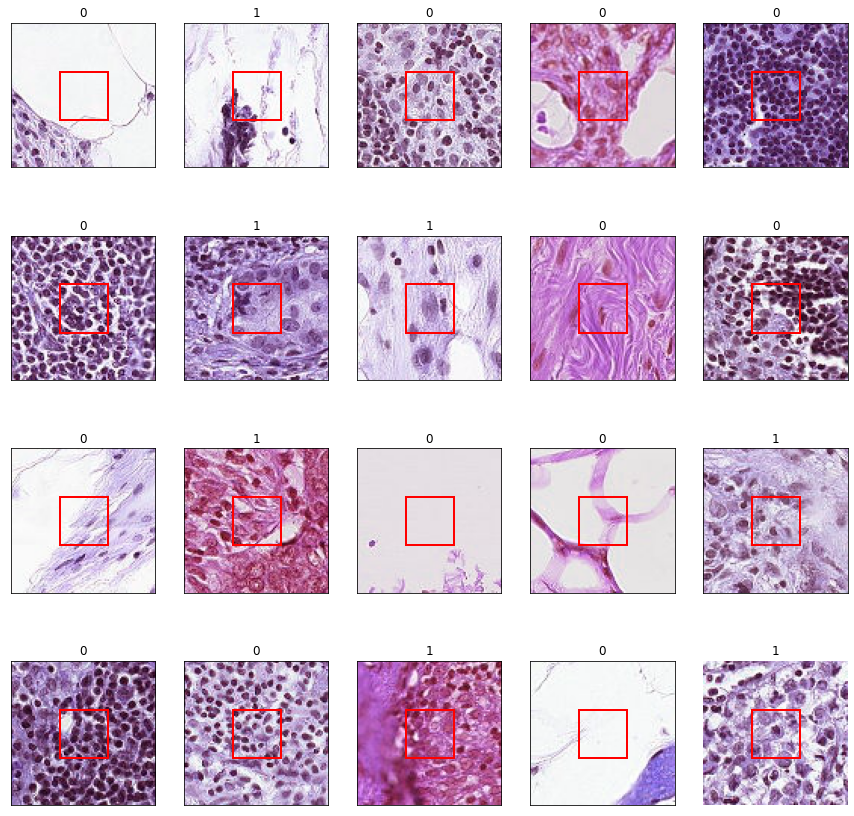

In [4]:
#read in training labels csv
df_train = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print(df_train.head())

#set a seed for reproductibility
rnd_seed = 176

#set seed to get same images
random.seed(rnd_seed)
#get "random" images to show
randsamp = random.sample(range(len(df_train)),25)

fig, axs = plt.subplots(4, 5, figsize=(15,15))
for i, ax in enumerate(fig.axes):
    #plt the random image
    ax.imshow(cv2.imread(train_path + df_train.iloc[i,0] + ".tif")); plt.axis('off')
    #Make rectangle for 32x32px patch in center and add to plt
    patch = patches.Rectangle((32,32),32,32, edgecolor='r',facecolor='none',linewidth=2)
    ax.add_patch(patch)
    #make the title 0 for no tumor, or 1 for tumer
    ax.set_title(df_train.loc[i,'label'])
    #remove tick marks
    ax.set(xticks=[], yticks=[])   

The above images give a sample of images in the training data set. The red square is the 32x32px patch. The label is 1 if there is tumor tissue in this patch. To my untrained eye, I do not see much to differentiate between the different class of images.

The data looks good. The information below shows there is no missing data. The histogram below shows the quantity of each label (0 and 1). The groups are slightly unbalanced. If this causes issues in our model training, we will look into this more.

In [5]:
#Confirm no null/missing values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Text(0.5, 1.0, 'Histogram of labels for training data')

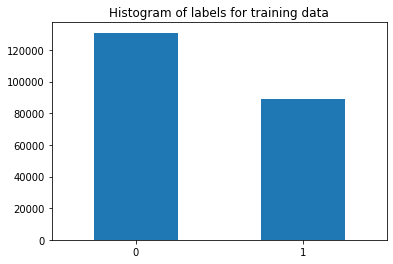

In [6]:
#make histogram from dataframe
df_train['label'].value_counts().plot(kind='bar',rot=0)
plt.title("Histogram of labels for training data")

# Plan of Analysis
We will load the images into a datset using Keras. We will split the training set to 0.8 training and 0.2 validation. During this stage there are many different preprocessing steps we could utilize on our images. The only one we will initally do is normalize the inputs to make all input between 0 and 1. We will do this by dividing the inputs by 255, since all the RGB values are on a scale from 0 to 255. This is an important step for neural networks to ensure that a single input doesn't have an outsized impact on the result. This is the only preprocessing step we will perform for at least the first model. We may trial additional preprocessing steps in a later step. 

This will then be the input to our CNN. We will construct multiple CNN structures and see what worked the best. 

The CNN structures we will trial:

1. Base model: A basic structure with 3 convultional layers, then a maxpool, followed by the classifier. The convulational layers will have a stride of 2 to reduce the number of parameters:
* conv x3 -> maxpool -> classifier

2. Extended and tuned model: Similar to number 1, but repeating the convultional layers and maxpool layers three times with batch normalization and dropout. The convulational layers will have a stride of 1, and then the classifier at the end:
* [conv and batchnormalization x3 -> maxpool -> dropout]x3 -> classifier


3. ResNet50 model: The third model will be one from keras.applications. We will use ResNet50 without the top (classifier portion) because we want to use our image size (96x96x3). We will add a similar classifier to the end as the previous two. 

The first model will not tune any hyperparameters. The second model has some hyperparemeters tuned, and the third is set up as used in the keras.applications. All models will use a "sigmoid" activation at the end because the result is binary (1 or 0). 

We will be passing the models the original images of 96x96 pixels. The label is only 1 if the center 32x32px patch contains tumor tissue. The region outside of the patch has no impact on the label. We are assuming that the neural network will be able to learn this and label them correctly even if there are tumor tissues outside of the 32x32 patch. 

# Load data with Keras

In [7]:
#define parameters for keras function
batch_size = 32
img_size = 96

# prepare dataframe for loading images into generator
df_train["id"] = df_train["id"].apply(lambda row: row + ".tif")
df_train['label'] = df_train['label'].astype(str)

# randomly shuffle training data
df_train = shuffle(df_train, random_state=rnd_seed)
df_train

,id,label
97800,f34bf6fd598f65787fd5cbea622ee4bdcb908df1.tif,1
106927,fe448070a477595c1a9289a4acce8b95ec439ec6.tif,0
123854,cac17c1730d4d12481087b01404b10c38e120f53.tif,1
201962,1befe03e28e9cdaf4829dae5c0050920b4eca807.tif,1
174528,9071a8033a9e90ed7945fc022e0bc5704f532a43.tif,0
...,...,...
117135,9d2b75f1b91ec77eea383f2d1edde3a7164f7126.tif,0
189308,b473f704419822a6a9fca1d74bcf41cfbadc54f0.tif,0
83701,356217b34d47b7a29e966dd7ab6d4dea7e5ea7ea.tif,0
27325,b58b6f714d78892182dd135e4f353dd9159181be.tif,0


In [8]:
# modify training data by normalizing it 
# and split data into training and validation sets
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.2)

In [9]:
# generate training data
train_data = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=batch_size,
    seed=rnd_seed,
    class_mode="binary",
    target_size=(img_size,img_size))

Found 176020 validated image filenames belonging to 2 classes.


In [10]:
# generate validation data
val_data = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=batch_size,
    seed=rnd_seed,
    class_mode="binary",
    target_size=(img_size,img_size))

Found 44005 validated image filenames belonging to 2 classes.


In [11]:
#create function to create CNN models
def createCNN(n = 1,kernel_size = (3,3), strides = 1, num_filters = 32, filt_mult = 1, bn = False, drop = False,
              pool_size = (2,2), dropout_c = 0.2, input_shape = (96, 96, 3)):
    '''
    n = number of layers of [conv2d*3, maxpool]
    kernel_size = size of filter, default 3x3 filter
    strides = stride for conv2d layers
    num_filters = number of filters in Conv2d layer
    filt_mult = multiplicative increase for filter number in later layers if n >1
    bn is batch normalization, if True, batch normalization after every conv2d
    drop is for dropout, if True adds dropout to end of each layer
    pool_size = window size to take the maximum, default is 2x2
    dropout_c = dropout rate for convultional layers, float between 0 to 1
    '''
    #initialize model
    model = Sequential()
    
    #Add n sets of layers to model
    for i in range(n):
        #add conv2d layer
        model.add(Conv2D(num_filters, kernel_size, strides = strides, activation = 'relu', input_shape = input_shape))
        #if bath normalization = True, add layer for it
        if bn:
            model.add(BatchNormalization())
        model.add(Conv2D(num_filters, kernel_size,strides = strides, activation = 'relu'))
        if bn:
            model.add(BatchNormalization())
        model.add(Conv2D(num_filters, kernel_size, strides = strides,activation = 'relu'))
        if bn:
            model.add(BatchNormalization())
            
        #add max pooling layer
        model.add(MaxPooling2D(pool_size = pool_size)) 
        #if dropout is True, add layer for it
        if drop:
            model.add(Dropout(dropout_c))
        
        #update the number of filters for the next set of layers
        num_filters = num_filters * filt_mult
    
    #add classifying layers to the end of model
    model.add(Flatten())
    model.add(Dense(256/4, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = "sigmoid"))
    
    #compile the model with Adam optimizer
    model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
    #return the model
    return model

In [43]:
#create function to create graphs of accuracy/loss
#for use later on
def modelGraphs(model, model_num, metrics):
    '''
    model = the model to create the graphs based on
    model_num: the index for the model in the notebook. The index
            in the model_acc variable
    metrics = the metrics to plot in graphs
    '''
    #Loop through each metric to make plot
    for metric in metrics:
        #make val_metric
        val_metric = "val_" + metric
        #plot metric
        plt.plot(np.arange(1,len(model.history.history[metric]) + 1),model.history.history[metric])
        #plot validation data metric
        plt.plot(np.arange(1,len(model.history.history[val_metric]) + 1),model.history.history[val_metric])
        
        #add title, axes labels and legend
        title_options = ['Base Model', 'Extended Model', 'ResNet50 Model']
        plt.title(title_options[model_num] + ": Epoch vs " + metric)
        plt.ylabel(metric)
        plt.xlabel('Epoch Number')
        plt.legend(['Train', 'Validate'], loc='best')
        plt.show();

In [13]:
#Create base model of only 1 layer with a stride of 2 and show summary
model1 = createCNN(n = 1,strides = 2)
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                51264     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                2

In [14]:
#fit the model to the data
model1.fit(train_data,validation_data= val_data,epochs=10)

Epoch 1/10
5501/5501 [==============================] - 1847s 333ms/step - loss: 0.4925 - accuracy: 0.7701 - val_loss: 0.4328 - val_accuracy: 0.8072
Epoch 2/10
5501/5501 [==============================] - 710s 129ms/step - loss: 0.4343 - accuracy: 0.8128 - val_loss: 0.4331 - val_accuracy: 0.8082
Epoch 3/10
5501/5501 [==============================] - 580s 106ms/step - loss: 0.4080 - accuracy: 0.8256 - val_loss: 0.3708 - val_accuracy: 0.8381
Epoch 4/10
5501/5501 [==============================] - 511s 93ms/step - loss: 0.3784 - accuracy: 0.8402 - val_loss: 0.5060 - val_accuracy: 0.7702
Epoch 5/10
5501/5501 [==============================] - 505s 92ms/step - loss: 0.3675 - accuracy: 0.8447 - val_loss: 0.3571 - val_accuracy: 0.8511
Epoch 6/10
5501/5501 [==============================] - 509s 93ms/step - loss: 0.3564 - accuracy: 0.8507 - val_loss: 0.3357 - val_accuracy: 0.8557
Epoch 7/10
5501/5501 [==============================] - 539s 98ms/step - loss: 0.3498 - accuracy: 0.8533 - val_los

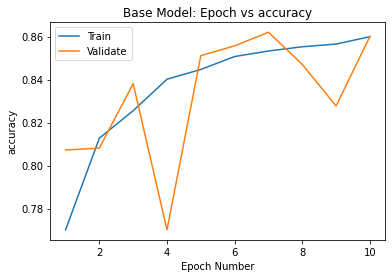

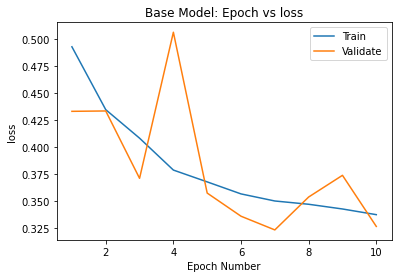

In [44]:
#save history to variable
model1_history = pd.DataFrame(data = model1.history.history)
#plot accuracy and loss vs epoch
modelGraphs(model1, 0, ['accuracy','loss'])

In [45]:
#Create model with 3 repeating layers of conv and maxpool, with batchnormalization and dropout
model2 = createCNN(n = 3,bn = True, drop = True)
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_11 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 92, 92, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)       

In [46]:
#fit model
model2.fit(train_data,validation_data= val_data,epochs=10)

Epoch 1/10
5501/5501 [==============================] - 742s 135ms/step - loss: 0.3956 - accuracy: 0.8270 - val_loss: 0.6092 - val_accuracy: 0.7354
Epoch 2/10
5501/5501 [==============================] - 547s 99ms/step - loss: 0.3271 - accuracy: 0.8636 - val_loss: 0.8102 - val_accuracy: 0.7300
Epoch 3/10
5501/5501 [==============================] - 544s 99ms/step - loss: 0.2893 - accuracy: 0.8838 - val_loss: 0.4493 - val_accuracy: 0.8372
Epoch 4/10
5501/5501 [==============================] - 543s 99ms/step - loss: 0.2650 - accuracy: 0.8959 - val_loss: 0.6316 - val_accuracy: 0.8012
Epoch 5/10
5501/5501 [==============================] - 531s 97ms/step - loss: 0.2463 - accuracy: 0.9042 - val_loss: 0.4194 - val_accuracy: 0.8321
Epoch 6/10
5501/5501 [==============================] - 537s 98ms/step - loss: 0.2477 - accuracy: 0.9041 - val_loss: 0.8883 - val_accuracy: 0.7974
Epoch 7/10
5501/5501 [==============================] - 580s 105ms/step - loss: 0.2372 - accuracy: 0.9087 - val_loss:

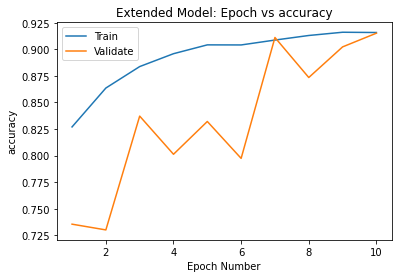

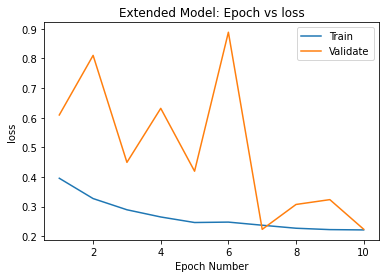

In [47]:
#save history to variable
model2_history = pd.DataFrame(data = model2.history.history)
#plot accuracy and loss vs epoch
modelGraphs(model2, 1, ['accuracy','loss'])

In [49]:
#use ResNet50 architecture to compare to what already tried
#won't include top so that we can input our shape of 96x96x3
#won't use weights because different application
base_model = tf.keras.applications.ResNet50(include_top = False, weights = None, pooling = "max", input_shape=(96, 96, 3))

#start top/classifier part of model
top_model = Sequential()

#create the classifier for the model similar to other models
#maxpool = MaxPooling2D(pool_size = (2,2))(base_model.layers[-1].output)
drop1 = Dropout(0.2)(base_model.layers[-1].output)  
flat1 = Flatten()(drop1)
dense1 = Dense(256/4, activation = "relu")(flat1)
bn1 = BatchNormalization()(dense1)
drop2 = Dropout(0.2)(bn1)    
dense2 = Dense(1, activation = "sigmoid")(drop2) 

#merge the bottom and top of the model together to create the model
model3 = tf.keras.Model(inputs=base_model.inputs,outputs=[dense2])

#compile with adam optimizer and show summary
model3.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

The ResNet50 model has almost 24 million paramters, while the other two had 70,977 (Base) and 150,145 (extended). So the ResNet model is much larger which can lead to a better model with more adaptability, but can also lead to overfitting if we are not careful. 

In [50]:
#fit the model
model3.fit(train_data,validation_data= val_data,epochs=10)

Epoch 1/10
5501/5501 [==============================] - 871s 157ms/step - loss: 0.3779 - accuracy: 0.8364 - val_loss: 0.5697 - val_accuracy: 0.7809
Epoch 2/10
5501/5501 [==============================] - 758s 138ms/step - loss: 0.2917 - accuracy: 0.8816 - val_loss: 0.5525 - val_accuracy: 0.7679
Epoch 3/10
5501/5501 [==============================] - 717s 130ms/step - loss: 0.2449 - accuracy: 0.9030 - val_loss: 0.3767 - val_accuracy: 0.8421
Epoch 4/10
5501/5501 [==============================] - 686s 125ms/step - loss: 0.2131 - accuracy: 0.9185 - val_loss: 0.4692 - val_accuracy: 0.8310
Epoch 5/10
5501/5501 [==============================] - 784s 142ms/step - loss: 0.1909 - accuracy: 0.9282 - val_loss: 0.7166 - val_accuracy: 0.7670
Epoch 6/10
5501/5501 [==============================] - 699s 127ms/step - loss: 0.1738 - accuracy: 0.9350 - val_loss: 0.3170 - val_accuracy: 0.8609
Epoch 7/10
5501/5501 [==============================] - 665s 121ms/step - loss: 0.1615 - accuracy: 0.9399 - val_

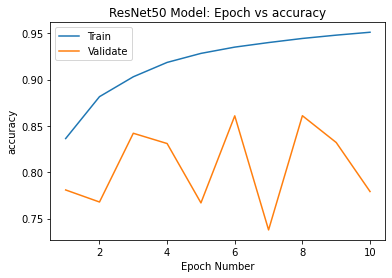

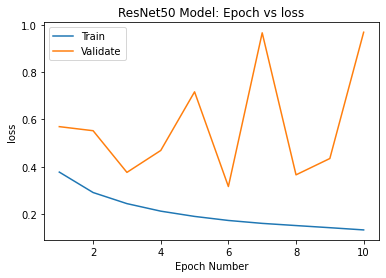

In [51]:
#save history to variable
model3_history = pd.DataFrame(data = model3.history.history)
#plot accuracy and loss vs epoch
modelGraphs(model3, 2, ['accuracy','loss'])

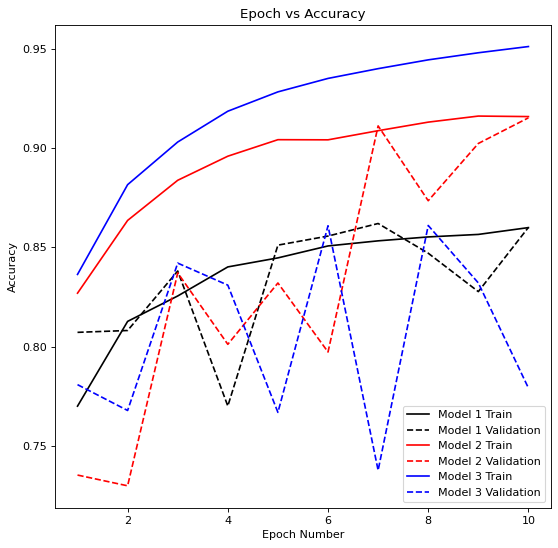

In [60]:
#plot all accuracies on one plot
val_metric = "val_accuracy"
x_epoch = np.arange(1,len(model1_history['accuracy']) + 1)
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(x_epoch,model1_history['accuracy'], 'k-',x_epoch,model1_history['val_accuracy'], 'k--')
plt.plot(x_epoch,model2_history['accuracy'], 'r-',x_epoch,model2_history['val_accuracy'], 'r--')
plt.plot(x_epoch,model3_history['accuracy'], 'b-',x_epoch,model3_history['val_accuracy'], 'b--')

#add title, axes labels and legend
plt.title("Epoch vs Accuracy")
plt.ylabel("Accuracy")
plt.xlabel('Epoch Number')
plt.legend(['Model 1 Train', 'Model 1 Validation','Model 2 Train', 'Model 2 Validation',
            'Model 3 Train', 'Model 3 Validation'], loc='best')
plt.show();

The epoch vs accuracy charts show that the validation errors are highly variable from epoch to epoch. This is not ideal and with more time, it would be useful to try to smooth out the performance.

The ResNet50 model (model3) has the highest accuracy on training data, but these charts show that the models we created (the first two) are generalizing much better than the ResNet50. The train and validation accuracy for the first two are much closer together, while there is a large gap for the ResNet50 model. This would indicate that the ResNet50 model is ovefitting. Based on this chart, the best model to use would be the Extended model (model 2), since we want the model to generalize well to unseen data. If we had more time to tune hyperparameters and reduce overfitting, the ResNet50 model could have performed better.  

# Results
We will look at confusion matrixes, roc curves, the training and validation losses, accuracies and area under the ROC curve (AUC) scores. Then we will also look at the test AUC scores.  

In [61]:
def predict_and_save_results(model, model_num):
    '''
    This function will predict for the train data and test data and then save the results
    model = model to predict from
    model_num = the model number
    '''
    #make predictions for the train and validation data to calculate the metrics
    yp = model.predict(train_data_eval, verbose=1)
    ypv = model.predict(val_data_eval, verbose=1)

    # Get the actual labels
    ya = train_data_eval.classes
    yav = val_data_eval.classes
    
    #determine if positive label or not if the prediction > 0.5
    yp_binary = np.where(yp>0.5,1,0)
    ypv_binary = np.where(ypv>0.5,1,0)
    
    #calculate metrics and save to variable to show in results table
    train_auc[model_num] = roc_auc_score(ya, yp)
    acc[model_num] = accuracy_score(ya,yp_binary)
    #loss[model_num] = log_loss(ya,yp)
    #val_loss[model_num] = log_loss(yav,ypv)
    val_acc[model_num] = accuracy_score(yav,ypv_binary)
    val_auc[model_num] = roc_auc_score(yav, ypv)

    #make confusion matrix
    ConfusionMatrixDisplay.from_predictions(ya,yp_binary,xticks_rotation='vertical')
    plt.show
    
    #make ROC curve plot
    fpr, tpr, thresholds = roc_curve(ya, yp)
    #auc_keras = auc(fpr, tpr)
    #print(auc_keras)
    plt.figure(2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = {:.3f}'.format(train_auc[model_num]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    #make test predictions
    yp_test = model.predict(test_data, verbose=1)
    
    #create df for submissions
    #predictions = np.transpose(predictions)[0]
    submission = pd.DataFrame()
    submission['id'] = df_test['id'].apply(lambda x: x.split('.')[0])
    submission['label'] = yp_test
    return submission
    

In [62]:
#initialize variables for results table
#loss = np.zeros(3)
acc = np.zeros(3)
#val_loss = np.zeros(3)
val_acc = np.zeros(3)
train_auc = np.zeros(3)
val_auc = np.zeros(3)
test_auc = np.zeros(3)

In [63]:
#create a dataframe for id of test images
df_test = pd.DataFrame({'id':os.listdir(test_path)})
df_test.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [64]:
#genrate test data that is not shuffled 
#for the model to use to make predictions on
datagen2 = ImageDataGenerator(rescale=1./255.)
test_data = datagen2.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col="id",
    batch_size=batch_size,
    seed=rnd_seed,
    class_mode=None,
    target_size=(img_size,img_size),
    shuffle=False)

Found 57458 validated image filenames.


In [65]:
# generate training data that is not shuffled to get ROC scores
train_data_eval = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=batch_size,
    seed=rnd_seed,
    class_mode="binary",
    target_size=(img_size,img_size),
    shuffle = False)

Found 176020 validated image filenames belonging to 2 classes.


In [66]:
# generate vaildation data that is not shuffled to get ROC scores
val_data_eval = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=batch_size,
    seed=rnd_seed,
    class_mode="binary",
    target_size=(img_size,img_size),
    shuffle = False)

Found 44005 validated image filenames belonging to 2 classes.


1376/1376 [==============================] - 147s 107ms/step


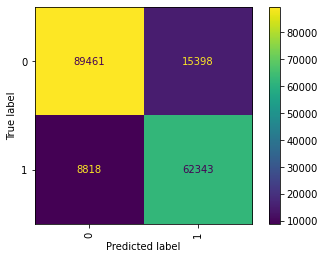

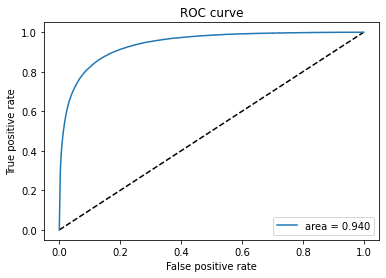

1796/1796 [==============================] - 514s 286ms/step


In [67]:
#use function to predict output values
submission1 = predict_and_save_results(model1, 0)
#convert to csv to submit to competition
submission1.to_csv('submission1.csv', index=False)

1376/1376 [==============================] - 152s 111ms/step


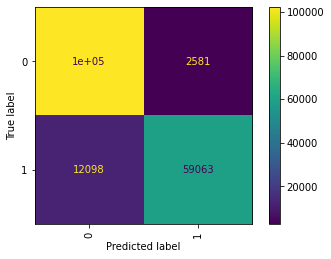

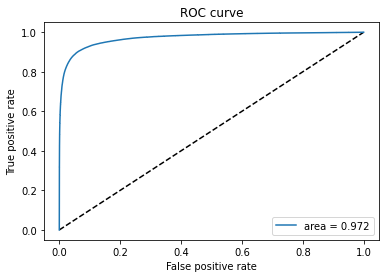

1796/1796 [==============================] - 191s 106ms/step


In [68]:
#use function to predict output values
submission2 = predict_and_save_results(model2, 1)
#convert to csv to submit to competition
submission2.to_csv('submission2.csv', index=False)

1376/1376 [==============================] - 145s 105ms/step


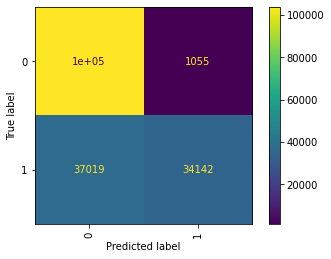

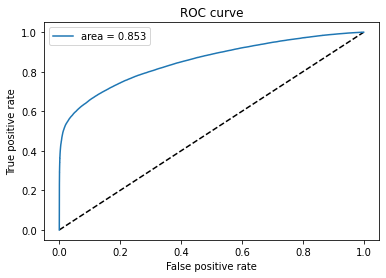

1796/1796 [==============================] - 162s 90ms/step


In [69]:
#use function to predict output values
submission3 = predict_and_save_results(model3, 2)
#convert to csv to submit to competition
submission3.to_csv('submission3.csv', index=False)

The ROC curve and the confusion matrixes show that the best model is model 2, the extended model. The confusion matrix for the first two models show that they do a pretty good job at predicting labels. Model 3's confusion matrix show that the ResNet50 model predicted way too many 0s. It only predicted ~35,000 label 1s, which is about 50% of the actual. 

In [72]:
#Set model names variables and number of parameters for results table
mod_names = ['Base Model', 'Extended Model', 'ResNet50 Model']
numparams = [70977,150145,23719169]

#input test AUC from kaggle to put in results table
test_auc = [0.9062,0.9223,0.7515]

In [73]:
#make results table
results = pd.DataFrame(list(zip(mod_names,numparams,acc,train_auc,val_acc,val_auc,test_auc)),
                       columns = ['Model','Number of Parameter','Training Accuracy', 'Training AUC',
                                  'Validation Accuracy', 'Validation AUC', 'Testing AUC'])
results

,Model,Number of Parameter,Training Accuracy,Training AUC,Validation Accuracy,Validation AUC,Testing AUC
0,Base Model,70977,0.862425,0.940139,0.860061,0.937581,0.9062
1,Extended Model,150145,0.916606,0.971627,0.915191,0.969245,0.9223
2,ResNet50 Model,23719169,0.783695,0.852646,0.779230,0.845890,0.7515


The best model is the Extended model with ~91% accuracy. All the models had similar performance between the training and validation data sets. The base and extended models had similar performance to what was shown during the model training. The ResNet50 accuracy is lower than what was shown during the model training. 

All the models seem to be overfitting a little bit, since the test data AUC is lower than the training and validation AUC. However, the validation metrics are very similar to the training metrics which would lead one to believe there is not much overfitting happening. More analysis would need to take place to determine why the testing results are lower than the others. Could there be an unidentified bias in the training or test sets?

Many hyperparameters were trialed and tuned throughout the process. Batch normalization, dropout, pooling, and number of layers all improved the models. Different variations of these hyperparameters were trialed at an initial stage, but only the 3 models shown in the table were kept for the results table due to time and GPU constraints. More hyperparameters could have been tuned with additional time and capacity. 

# Conclusions
Convolutional neural networks (cnn) are a very useful tool for analyzing images. From the images we started with, I could not tell the difference between the no tumor and has tumor tissue classes. However, by using a cnn, our best model was able to predict the validation data set with 91% accuracy! And its test set had an area under the curve (AUC) of 0.9223! Those are amazing results for a initial application of CNN. 

CNNs are a powerful tool, but there are also some things that you need to be careful about. They can overfit the data and lead to poor validation/test results. They also take a long time to train. The models in this notebook each took ~1 to 2 hours to train on a GPU. So if you don't know what you are doing, you can waste a lot of time trying to train a model incorrectly. 

There are a few things that could be looked at in the future to potentially could improve the model. First, there are some images that are very dark or very bright, we could analyze the images and remove any images that are too dark or too bright. Second, the label is only 1 if the 32x32px square in the center of the image contains tumor tissue. We could crop the image to this section or do something similar to remove at least a portion of the unnecessary section of the image. Third, there are many, many more preprocessing and tuning that could be done. In the future, it would be great to try more of these steps and tunings to see how they affect the models. 

# References
The following notebooks and websites were very useful:

* https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb?scriptVersionId=7784920
* https://www.tensorflow.org/tutorials/load_data/images
* https://www.kaggle.com/code/joehardin369/introduction-to-deep-learning-week-3